In [1]:
!git clone https://github.com/fh2c1/Anonymize-Anyone.git
%cd /content/Anonymize-Anyone
!pip install peft
!pip install diffusers
!pip install -r requirements.txt

Cloning into 'Anonymize-Anyone'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 102 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 12.06 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/Anonymize-Anyone
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manyli

In [2]:
import PIL
import peft
import copy
import torch
import random
import os, sys
import argparse
import requests
from io import BytesIO
from IPython.display import display
from torchvision.ops import box_convert
from PIL import Image, ImageDraw, ImageFont
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "fh2c1/Anonymize-Anyone",
    torch_dtype=torch.float16,  safety_checker=None,
).to(device)

sd_pipe.load_lora_weights("fh2c1/SimPO-LoRA", adapter_name="SimPO")
sd_pipe.set_adapters(["SimPO"], adapter_weights=[0.5]) # you can play with adapter_weights to increase the effect of the LoRA model

model_index.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/6.68M [00:00<?, ?B/s]

In [4]:
def generate_image(image_path, mask_path, prompt, negative_prompt, pipe, seed):
    try:
        in_image = Image.open(image_path)
        in_mask = Image.open(mask_path)
    except IOError as e:
        print(f"Loading error: {e}")
        return None

    generator = torch.Generator(device).manual_seed(seed)

    result = pipe(image=in_image, mask_image=in_mask, prompt=prompt,
                  negative_prompt=negative_prompt, generator=generator)
    result = result.images[0]

    return result

In [33]:
image = '/content/Anonymize-Anyone/data/1.png'
mask = "/content/Anonymize-Anyone/data/1_mask.png"

prompt = "He is an Asian adult with a confident posture and a clear gaze."
seed = random.randint(-15151515, 1518181818181818)

negative_prompt = "low resolution, ugly, disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w, deformed eyes, low quailty, noise"

  0%|          | 0/50 [00:00<?, ?it/s]

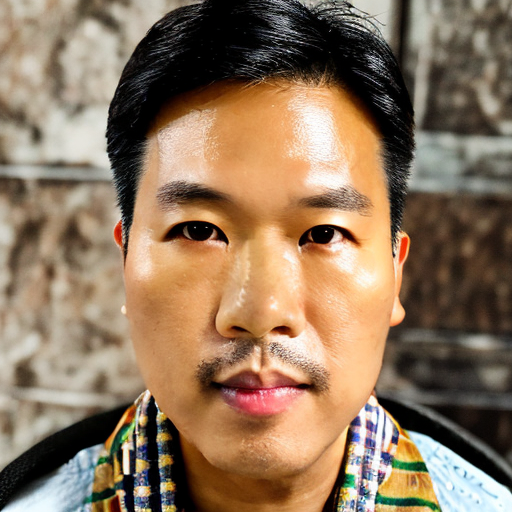

In [34]:
try:
    generated_image = generate_image(image_path=image, mask_path=mask, prompt=prompt,
                                     negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
except TypeError as e:
    print(f"TypeError : {e}")

generated_image